In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import prophet
import pmdarima as pm
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [23]:
df = pd.read_csv("data/all_stocks_5yr.csv")
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [24]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


C:\Users\1\AppData\Local\Temp\ipykernel_6564\70263389.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')


In [25]:
def subdataframe(df, tick):

    # top 10 ticks


    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [26]:
bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')

In [27]:
aapl_df

,date,open,high,low,close,volume,ticks
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL
...,...,...,...,...,...,...,...
2513,2018-02-01,167.1650,168.6200,166.7600,167.7800,47230787,AAPL
2514,2018-02-02,166.0000,166.8000,160.1000,160.5000,86593825,AAPL
2515,2018-02-05,159.1000,163.8800,156.0000,156.4900,72738522,AAPL
2516,2018-02-06,154.8300,163.7200,154.0000,163.0300,68243838,AAPL


In [28]:
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)

    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)

In [29]:
def price_forecasting(df, period):

    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)

    # plot the components
    fig2 = prophet.plot_components(forecasts)

    return forecasts

12:55:24 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing


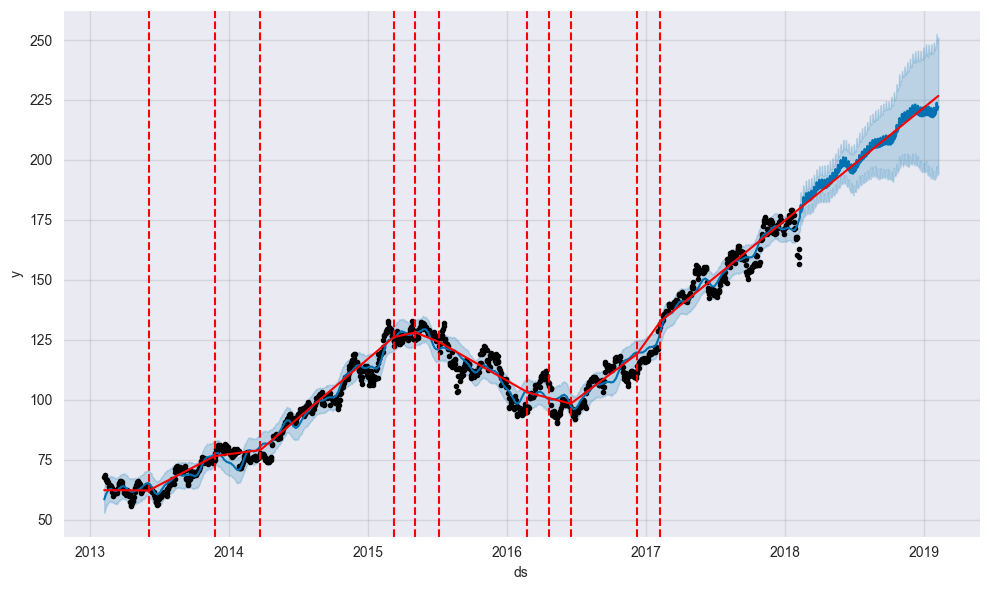

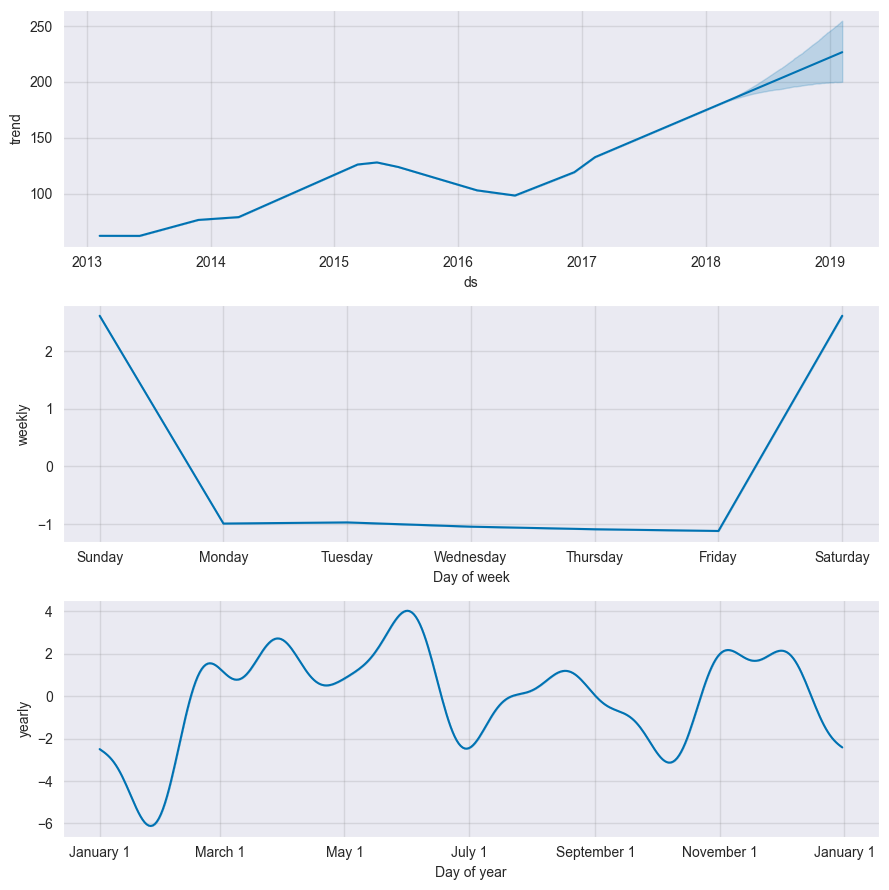

In [30]:
forecast_aapl = price_forecasting(aplph_df, 365)

In [35]:
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]

    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")

    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')

data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------


C:\Users\1\AppData\Local\Temp\ipykernel_6564\3773506546.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_df = (df['y'])[:size]
C:\Users\1\AppData\Local\Temp\ipykernel_6564\3773506546.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_df = (df['y'])[size:]


In [53]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf',
                          start_p = 1, start_q = 1,
                          max_p = 10, max_q = 10,
                          d = None, seasonal = True,
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')


    return model

model_apl = find_best_fit_arima(apl_train, 'APPLE')

Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5737.373, Time=0.17 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4795.557, Time=0.39 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5191.240, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5746.692, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5067.196, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4657.095, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5740.397, Time=0.14 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4647.664, Time=0.29 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4777.434, Time=0.16 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   

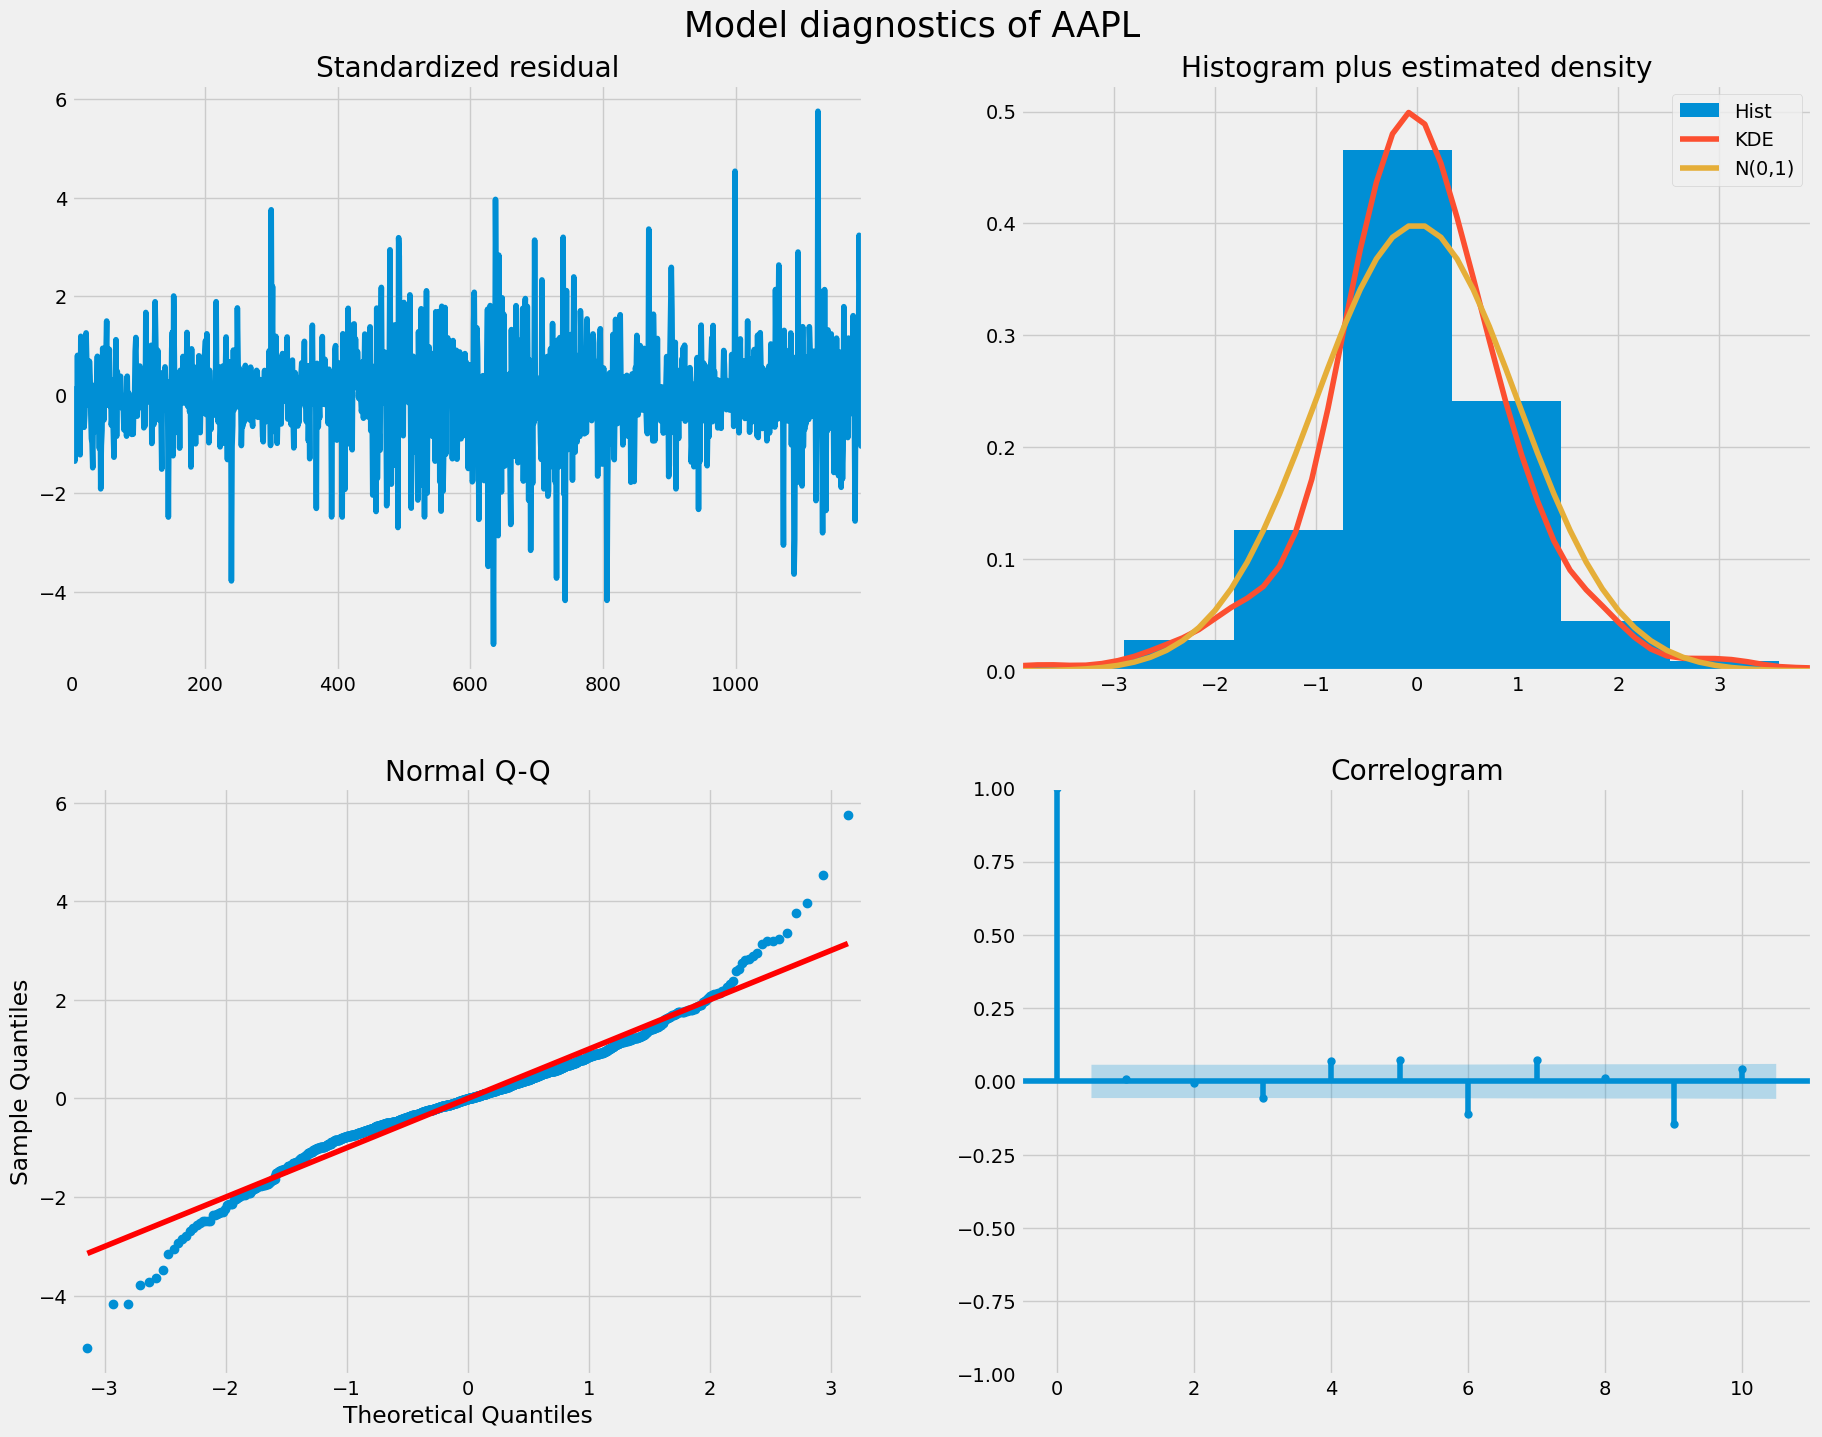

In [54]:
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')

display_model_plots(model_apl, 'AAPL')

forecasting and RMSE of APPLE
RMSE is:  123.24439040817172


C:\PyCharm_Prjs\finance_forecasting\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\1\AppData\Local\Temp\ipykernel_6564\2320392980.py:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
C:\Users\1\AppData\Local\Temp\ipykernel_6564\2320392980.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`

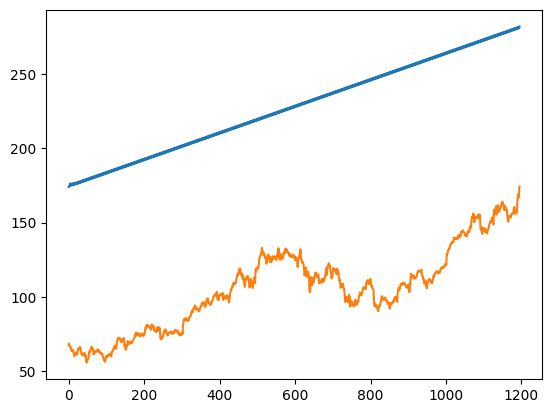

In [55]:
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")

    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    plt.plot(forecast.values)
    plt.plot(test_df.values)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)

    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))

    print("RMSE is: ", rmse)

    return forecasts, lower, upper

forecast, lower, upper = make_predictions_and_print_rmse(model_apl, apl_train, 'APPLE')